#Natural Language Processing with Disaster Tweets

Predict which Tweets are about real disasters and which ones are not

https://www.kaggle.com/c/nlp-getting-started/overview

In [ ]:
from google.colab import drive

In [ ]:

drive.mount("/content/colab/")

Mounted at /content/colab/


In [ ]:
%cd "colab/MyDrive/Assignment6"

/content/colab/MyDrive/Assignment6


In [ ]:
!ls

sample_submission.csv  test.csv  train.csv


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Frame the problem

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running. 

This is a **Binary classification problem**.

using F1 score means we care about precision and recall equally;we don't want the model to have either a high precision or a high recall.

# Get the data

In [ ]:

train_data =pd.read_csv("train.csv")

In [ ]:
test_data=pd.read_csv("test.csv")

In [ ]:
train_data[train_data["keyword"].isnull()==False]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [ ]:
train_data["text"][4]

'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '

In [ ]:
train_data["text"][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

The dataset is snamml, with only 7613

# Data exploration and EDA



First, let's check the class distribution.


In [ ]:

real_disaster=train_data[train_data["target"]==1].shape[0]
fake_disaster=train_data[train_data["target"]==0].shape[0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


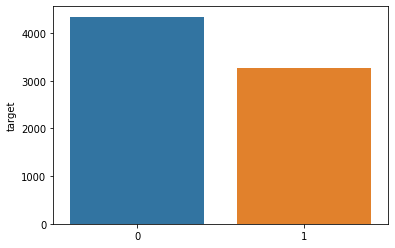

In [ ]:
import  seaborn  as sns

x = train_data.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_label("samples")



The class distribution tells us that There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)


## Explore columns

In [ ]:
train_data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train_data["location"].value_counts()

USA                      104
New York                  71
United States             50
London                    45
Canada                    29
                        ... 
ITALY                      1
We're All Mad Here         1
In @4SkinChan 's arms      1
#expelcl*y                 1
Hartford, Connecticut      1
Name: location, Length: 3341, dtype: int64

## Feature engineering

A good practice is to **visualize train and test set to know if they come from the same distribution.**

## Wordcloud

In [ ]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Disaster tweets

In [ ]:


corpus_disaster=create_corpus_df(train_data,1)
len(corpus_disaster)

49613

In [ ]:
corpus_disaster[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH']

Non-disaster

In [ ]:
corpus_not_disaster=create_corpus_df(train_data,0)
len(corpus_not_disaster)

63848

In [ ]:
corpus_not_disaster[:10]

["What's", 'up', 'man?', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

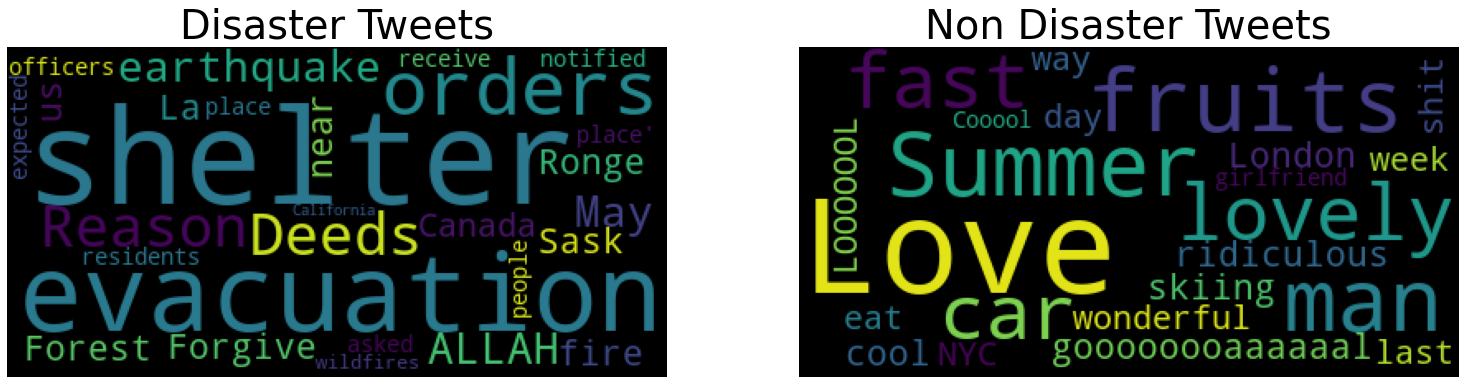

In [ ]:


from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_disaster[:50]))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_not_disaster[:50]))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);



Looks  like there's a huge difference between the common words in both categoris.

# Data Cleaning

## Duplicates
### dataset level

In [ ]:
train_data[train_data.duplicated(keep=False)].reset_index()

,index,id,keyword,location,text,target


### dataset  without target; __ Mislabeled Samples?__

Since this is a human-labelled data, we should check duplicates without the target column; a person might think that this is a disaster tweet while another person doesn't. This could affect the model's performance

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
train_data[train_data[["text","target"]].duplicated()]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1156,1665,bombing,Singapore,Japan on Thursday marks the 70th anniversary o...,1
1251,1807,buildings%20on%20fire,UK,#TweetLikeItsSeptember11th2001 Those two build...,1
1332,1924,burning%20buildings,"St Charles, MD",I'm mentally preparing myself for a bomb ass s...,0
1335,1929,burning%20buildings,NaN,@fewmoretweets all lives matter. Just not a fa...,1


other duplicates appeared, since  for some tweets,different keywords are extracted

In [ ]:
train_data.drop_duplicates(subset=["text","target"],keep="first",inplace=True)

In [ ]:
#df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)

train_grouped_by_text=train_data.groupby(["text"]).nunique().sort_values(by="target",ascending =False)
train_mislabeled = train_grouped_by_text[train_grouped_by_text["target"]>1]["target"]
train_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

There are 18 unique tweets in training set which are labeled differently in their duplicates. Those tweets are probably labeled by different people and they interpreted the meaning differently because some of them are not very clear. Tweets with two unique target values are relabeled since they can affect the training score.

In [ ]:
#visually inspecting
train_data[train_data["text"]==train_mislabeled.index.tolist()[1]]

,id,keyword,location,text,target
4306,6113,hellfire,NaN,Hellfire! We donÛªt even want to think about ...,0
4320,6134,hellfire,Riyadh '),Hellfire! We donÛªt even want to think about ...,1


In [ ]:
pd.set_option('display.max_rows', 5)

####  manual  labeling

In [ ]:
train_data.loc[train_data["text"] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit'
            ,"target"]=0

train_data.loc[train_data["text"] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife'
            ,"target"]=0

train_data.loc[train_data["text"] == 'To fight bioterrorism sir.'
            ,"target"]=0

train_data.loc[train_data["text"] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4'
            ,"target"]=1

train_data.loc[train_data["text"] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring'
            ,"target"]=1

train_data.loc[train_data["text"] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption'
            ,"target"]=0

train_data.loc[train_data["text"] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!'
            ,"target"]=0

train_data.loc[train_data["text"] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE'
            ,"target"]=1


train_data.loc[train_data["text"] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG'
            ,"target"]=1

train_data.loc[train_data["text"] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh..."
            ,"target"]=0

train_data.loc[train_data["text"] == 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon'
            ,"target"]=1
            
train_data.loc[train_data["text"] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam"
            ,"target"]=0

train_data.loc[train_data["text"] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!"
            ,"target"]=0


train_data.loc[train_data["text"] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'"
            ,"target"]=0

train_data.loc[train_data["text"] == "Caution: breathing may be hazardous to your health."
            ,"target"]=1


train_data.loc[train_data["text"] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????"
            ,"target"]=0

train_data.loc[train_data["text"] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect"
            ,"target"]=0


train_data.loc[train_data["text"] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time"
            ,"target"]=0


remove duplicates on the level of;text,target

In [ ]:
train_data[train_data[["text","target"]].duplicated(keep=False)].reset_index()

,index,id,keyword,location,text,target
0,610,881,bioterrorism,NaN,To fight bioterrorism sir.,0
1,624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...,...
34,6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward t...,0
35,6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward t...,0


In [ ]:
train_data[train_data[["text","target"]].duplicated()]

,id,keyword,location,text,target
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
...,...,...,...,...,...
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward t...,0


### merging train and test set

In [ ]:
merged=pd.concat((train_data,test_data),ignore_index=True)

In [ ]:
merged["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Checknull values

In [ ]:
merged.isnull().sum()/ merged.shape[0]*100

id           0.000000
keyword      0.760386
location    33.336424
text         0.000000
target      30.257789
dtype: float64

## Location

This is a user input column;either  do  extensive cleaning or don't use it as a feature.

# Fill NA's

33% of the location column is missing, and 0.8 from the keyword column is missing. 
The location:

              1.can't be derived from the dataset's other features
              2. a large proportion of it is missing
              3. Is a user-input column so needs extensive cleaning

**for these reasons, I decided to drop the location column**

The keyword column isn't that challenging, as 0.8 isn't of concern.

# Prepare the data for Machine Learning algorithms

## Data encodinnng

1. keyword >> single word>> 221 unique words>> OHE
2. location>>  multiple words>> 3341 unique locations>> tokenize then CountVectorizer
3. text>> sentences>> TF-IDF
hashtags ike #wildefires repeat in the corpus, we want to give these words higher weights, this is why I used tf-idf.

## Text Cleaning and preprocessing

As we know,tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.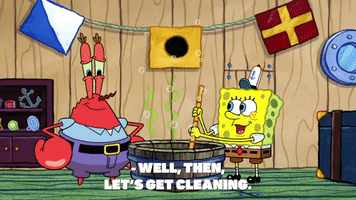

- text col>> remove any mentions (words after @), as it doesn't give us any information about the accident
- a common question to think about; do we need to keep/remove stop words? Since I'll be using BoW, stopwords won't have any effect.

- we want our model to focus on hashtags, so we shouldn't remove them.

- we want to remove any URL's in the text col.

- do we need to lowercase or does uppercase words helps conclude if this was a real disaster or not?
I would say that uppercase words don't essentialy mean that it's a disaster or not. as in the 3rd observation, it was a real disaster but not a single word was capitalized, however this could change in other examples, so lowercasing is better.

Now, TF-IDF removes punctuation and tokenizes words by default. so I'll skip these 2 functions in the following preprocessing pipeline:

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
' '.join(word for word in train_data["text"][31].split(' ') if not word.startswith('@'))

'Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [ ]:
' '.join(word for word in train_data["text"][31].split(' ') if not word.startswith('http'))

'@bbcmtd Wholesale Markets ablaze'

## Removing HTML tags

In [ ]:
def remove_html(text):
    html=re.compile(r"<.*?>")
    return  html.sub(r'',  text)


This should happen before all other preprocessing steps, as we will see in the full pipeline, since it will help sentence and words tokenization for example, and will reduce vocab.

In [ ]:

#merged["text"]=merged["text"].apply(lambda x:remove_html(x))

##  Removinng  urls  annd mentions

In [ ]:
train_data.tail(30)

,id,keyword,location,text,target
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


**Should we keep/remove mentions?**

Mentions to people can be irrelevant (moslty in the non-disaster tweets).

However, menntionns to organizatios could be critical  for  helping  the model  learn target  tweets. An   example:

In [ ]:
train_data["text"][7596]

'RT @LivingSafely: #NWS issues Severe #Thunderstorm Warnings for parts of #AR #NC #OK. Expect more trauma cases: http://t.co/FWqfCKNCQW'

In [ ]:
#remove mentions
#def remove_mentions(text):
 # return ' '.join(word for word in text.split(' ') if not word.startswith('@'))
  #returns the sentence, after removing the mention

#remove URLs
def remove_urls(text):
  #slower than regex
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
  #returns the sentence, after removing the url
  
remove_urls(train_data["text"][31])

'@bbcmtd Wholesale Markets ablaze '

In [ ]:
merged

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
...,...,...,...,...,...
10782,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10783,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [ ]:

#merged["text"]=merged["text"].apply(lambda x:remove_urls(x))

In [ ]:
merged

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
...,...,...,...,...,...
10782,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10783,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


## Removing emojis

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [ ]:

#merged["text"]=merged["text"].apply(lambda x:remove_emoji(x))

## Removing punctuation

**This will also remove hashtags**

In [ ]:
def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:

#merged["text"]=merged["text"].apply(lambda x:remove_punctuation(x))

In [ ]:
merged["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Spelling Correction

In [ ]:
!pip install pyspellchecker==0.5.3

     |████████████████████████████████| 1.9MB 8.3MB/s 


For some reason, the newest version couldn't correct the "please" word in the example below

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)


'correct me please'

In [ ]:

# merged["text"]=merged["text"].apply(lambda x:correct_spellings(x))
#this took a huge amout of time to  execute

In [ ]:
merged

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
...,...,...,...,...,...
10782,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10783,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


## Text pre-processing pipeline (Putting it all together)

In [ ]:

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

def remove_html(text):
    html=re.compile(r"<.*?>")
    return  html.sub(r'',  text)
   # This should happen before all other preprocessing steps,
   # as we will see in the full pipeline, since it will help sentence and words tokenization for example, and will reduce vocab. 
   

def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


#7599:#Earthquake
#other   examples: earthquake, EARTHQUAKE

def to_lowercase(text):
    return text.lower()

#remove URLs
def remove_urls(text):
  #slower than regex
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def text2words(text):
  return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text=remove_html(text)
    text=remove_urls(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    

    text = replace_numbers(text)
    words = text2words(text)
    #REMOVE STOPWORDS?
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [ ]:
train_data["text"][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [ ]:
merged["text"][31]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'

In [ ]:
clean_text(merged["text"][33])

'africanbaze break newsnigeria flag set ablaze aba'

In [ ]:
merge_clean=merged.copy()

In [ ]:
merge_clean

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
...,...,...,...,...,...
10782,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10783,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [ ]:
merge_clean["text"]=merge_clean["text"].apply(lambda x:clean_text(x))

In [ ]:
merged["text"][33]

'#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'

In [ ]:
merge_clean["text"][33]

'africanbaze break newsnigeria flag set ablaze aba'

**ALWAYS** visually inspect your outputs to make sure they are what you're  expecting

In [ ]:
#train_data["text"][33]

In [ ]:
merge_clean["text"][2]

'resident ask shelter place notify officer evacuation shelter place order expect'

shelter in place>>shelter  place.

# Bag of Words

The term BoW is used in many different occasions in NLP. In general, it referes to treating every word equally as the others, without consideration of sequential information of the sentence or document. In other words, **the context of the words is not considered. **


__For each piece of text → Put in the bag what is in 
the text__

In some settings, words in the bag are summed, averaged,...etc (or their vectors). In other settings, they are simply mutlipled by different _learnable_ weighting. This is the case we will consider. We will use the `Dense` layer, applied to a _long_ vector of 1's and 0's. The length of that vector is the same as the number of words in our vocab (we specified when loading the data above using the `num_words` param). We will have such vector for every sentence/document of the data. Whenever a word of the vocab is mentioned, we set the corresponding location to 1. Otherwise, it's 0. 

__You can imagine how sparse and inefficient is that vector!__

__In this setting, we are treating the mention or absence of a word as a feature__

The `Dense` layer will assign a _learnable_ weight to each word location. If the word is mentioned, that weight will be multiplied by 1, else it's 0. Then the output of the `Dense` is a number of neurons (hyper param), each represents different weighting of the input long vector of features/words.

The next layers, are just further _refinements_ of the learnt features from the previous layers. Until we reach the final layer, which produces 1 or k outputs according to the problem or task (binary or multi classification).

__Pros__:
- All words are normalized, regardless of their index in the vocab

__Cons__:

- Sparsity = inefficiency = A lot of useless features = confusion of the model = unnecessary big model = more overfitting

- Need to pad to max (again inefficiency): 

This model, requires ALL the data samples to have the same length, sense the `Dense` layer cannot handle variable length input (weight matrix is fixed). This mandates to perform padding

- No context = no sequence = hard to model co-reference, sarcasm, negation...etc

_


 I'll Train 3 BoW models for the following features:
- Binary
- Count + Freq
- TF-IDF

### 1.Binary

In binary Bow, each sentence is represented by a binary array with a length = length of the vocabulary. 
each item in the array  has a value of 1,if the word exists in the sentence.
and a value of 0 if it doesn't.

In [ ]:
from keras.preprocessing.text import Tokenizer
# Fit the tokenizer

# Either pre-define vocab size
# Or get the max possible vocab from text

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(merge_clean["text"])


In [ ]:
len(x)

2

#### split   train and test data

In [ ]:


x_train = tok.texts_to_matrix(merge_clean["text"][:7521], mode="binary")
x_val = tok.texts_to_matrix(merge_clean["text"][7521:], mode="binary")
y_train = np.asarray(merge_clean["target"][:7521]).astype("float32")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
#merge_clean.drop("target",axis=1,inplace=True)

In [ ]:
# train = x[:7521]
# x_test=x[7521:]

# y=merge_clean[7521:]["target"]
# y=np.asarray(y).astype('float32')
# y_test=merge_clean[7521:]["target"]

# x_train = train[:5264]
# x_val = train[5264:]

# y_train = y[:5264]
# y_val = y[5264:]

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a **"validation set"** by setting apart 2256 samples(30% of the data) from the original training data.

In [ ]:
x_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
x_train.shape

(5264, 10000)

#### Model

##### Building our network

Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected (Dense) layers with relu activations: Dense(16, activation='relu')

In [ ]:


model=models.Sequential()
#  a sigmoid "squashes" arbitrary values into the [0, 1] interval, 
#thus outputting something that can be interpreted as a probability.
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________



Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice, But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [ ]:

model.compile(optimizer   = optimizers.RMSprop(lr=.001),
              loss  = "binary_crossentropy",
              metrics= ["binary_accuracy"])

In [ ]:

history=model.fit(x_train,
                  y_train,
                  epochs=20,
                  batch_size=512,
                  validation_data =  (x_val,y_val))

Epoch 1/20
11/11 [==============================] - 2s 117ms/step - loss: 0.6843 - binary_accuracy: 0.5909 - val_loss: 0.6549 - val_binary_accuracy: 0.6690
Epoch 2/20
11/11 [==============================] - 1s 50ms/step - loss: 0.6320 - binary_accuracy: 0.7478 - val_loss: 0.6097 - val_binary_accuracy: 0.7559
Epoch 3/20
11/11 [==============================] - 1s 48ms/step - loss: 0.5711 - binary_accuracy: 0.8159 - val_loss: 0.5686 - val_binary_accuracy: 0.7860
Epoch 4/20
11/11 [==============================] - 0s 44ms/step - loss: 0.5069 - binary_accuracy: 0.8561 - val_loss: 0.5344 - val_binary_accuracy: 0.8002
Epoch 5/20
11/11 [==============================] - 0s 38ms/step - loss: 0.4536 - binary_accuracy: 0.8758 - val_loss: 0.5059 - val_binary_accuracy: 0.8068
Epoch 6/20
11/11 [==============================] - 0s 36ms/step - loss: 0.4028 - binary_accuracy: 0.8878 - val_loss: 0.4851 - val_binary_accuracy: 0.8059
Epoch 7/20
11/11 [==============================] - 0s 36ms/step - lo

####  Plot the learning curve

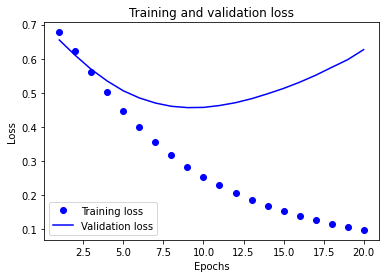

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Clearly,the model startedo  overfitting  from the 5th  epoch. Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

In [ ]:

model=models.Sequential()
#  a sigmoid "squashes" arbitrary values into the [0, 1] interval, 
#thus outputting something that can be interpreted as a probability.
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers
model.compile(optimizer   = optimizers.Adam(lr=.001),
              loss  = "binary_crossentropy",
              metrics= ["binary_accuracy"])

history=model.fit(x_train,
                  y_train,
                  epochs=5,
                  batch_size=512,
                  validation_data =  (x_val,y_val))

Epoch 1/5
11/11 [==============================] - 1s 54ms/step - loss: 0.6885 - binary_accuracy: 0.5891 - val_loss: 0.6741 - val_binary_accuracy: 0.6354
Epoch 2/5
11/11 [==============================] - 0s 42ms/step - loss: 0.6595 - binary_accuracy: 0.6814 - val_loss: 0.6444 - val_binary_accuracy: 0.6943
Epoch 3/5
11/11 [==============================] - 0s 45ms/step - loss: 0.6152 - binary_accuracy: 0.7676 - val_loss: 0.6058 - val_binary_accuracy: 0.7475
Epoch 4/5
11/11 [==============================] - 0s 40ms/step - loss: 0.5574 - binary_accuracy: 0.8204 - val_loss: 0.5646 - val_binary_accuracy: 0.7816
Epoch 5/5
11/11 [==============================] - 0s 33ms/step - loss: 0.4926 - binary_accuracy: 0.8603 - val_loss: 0.5266 - val_binary_accuracy: 0.7988


In [ ]:
x_train[0].shape

(10000,)

In [ ]:
results = model.evaluate(x_val, y_val)

71/71 [==============================] - 0s 2ms/step - loss: 0.5266 - binary_accuracy: 0.7988




Our binary BoW model reaches a  loss: 0.5691 - binary_accuracy: 0.7842


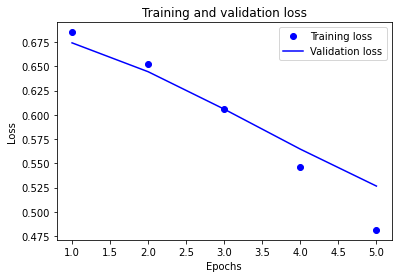

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Metric

The leaderboard is based on Mean F-Score which can be implemented with Macro Average F1 Score. However, it won't be very informative without Accuracy, Precision and Recall because classes are almost balanced and it is hard to tell which class is harder to predict.

   - Accuracy measures the fraction of the total sample that is correctly identified
  -  Precision measures that out of all the examples predicted as positive, how many are actually positive
  -  Recall measures that out of all the actual positives, how many examples were correctly classified as positive by the model
  -  F1 Score is the harmonic mean of the Precision and Recall


In [ ]:

model=models.Sequential()
#  a sigmoid "squashes" arbitrary values into the [0, 1] interval, 
#thus outputting something that can be interpreted as a probability.
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
#from sklearn import model_selection

#scores = model_selection.cross_val_score(model, train, y, cv=3, scoring="f1")
#

manually...**comeLater**

### 2.Count 

 Put the number of times the word is mentioned 
in a review **bold text**


The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words
- punctuation is completely ignored and always treated as a token separator
- The matrix is (CSR) (Compressed Sparse Row), which is more compact representation for matrices with many zeros. The BoW is very sparse, it's a good way to represent it. You can easily recover the array when needed using toarray()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer

In [ ]:

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(merge_clean["text"])

x_train = tok.texts_to_matrix(merge_clean["text"][:7521], mode="count")
x_val = tok.texts_to_matrix(merge_clean["text"][7521:], mode="count")
y_train = np.asarray(merge_clean["target"][:7521]).astype("float32")


In [ ]:
merge_clean["text"][0]

In [ ]:

# bow_cv=CountVectorizer()
# x_text_cv = bow_cv.fit_transform(merge_clean["text"])

In [ ]:
# x_text_cv.shape

In [ ]:
#bow_cv.vocabulary_

In [ ]:
# x_text_cv.toarray()

In [ ]:
len(x_text_cv.toarray()[0])

####   train-test split

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [ ]:
# train = x_text_cv[:7521].toarray()
# x_test=x_text_cv[7521:].toarray()

# y=merge_clean[:7521]["target"]
# y=np.asarray(y).astype('float32')
# y_test=merge_clean[7521:]["target"]

# x_train = train[:5264]
# x_val = train[5264:]

# y_train = y[:5264]
# y_val = y[5264:]

In [ ]:
x_train.shape

#### Modeling

In [ ]:

model=models.Sequential()
#  a sigmoid "squashes" arbitrary values into the [0, 1] interval, 
#thus outputting something that can be interpreted as a probability.
model.add(layers.Dense(16,activation="relu",input_shape=(10000,)))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

In [ ]:
x_train

In [ ]:

model.compile(optimizer   = optimizers.Adam(lr=.001),
              loss  = "binary_crossentropy",
              metrics= ["binary_accuracy"])

history=model.fit(x_train,
                  y_train,
                  epochs=5,
                  batch_size=512,
                  validation_data =  (x_val,y_val))

In [ ]:
results = model.evaluate(x_val, y_val)

loss: 0.5449 - binary_accuracy: 0.7984

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 3.Frequency

 **Normalized counts by total words counts**


The problem with the counts is that they are not normalized values, which is not good for the NN (neurons activations prefer 
normalized values, however, it makes no big difference for Dense and Relu ).
However,  unnormalized counts is the same as binary BoW, since high frequency words will dominate the 
vector, specially that it's very sparse, causing *quick overfitting*. In other words, important low freq words are discarded. This 
can be treated with TF-IDF, or at least by normalizing, so the network might understand that low frequencies have special 
importance.

In [ ]:

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(merge_clean["text"])

x_train = tok.texts_to_matrix(merge_clean["text"][:7521], mode="freq")
x_test = tok.texts_to_matrix(merge_clean["text"][7521:], mode="freq")

y_train = np.asarray(merge_clean["target"][:7521]).astype("float32")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)



In [ ]:
x_train

In [ ]:

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

Epoch 1/20
11/11 [==============================] - 2s 74ms/step - loss: 0.6908 - binary_accuracy: 0.5522 - val_loss: 0.6835 - val_binary_accuracy: 0.5835
Epoch 2/20
11/11 [==============================] - 0s 45ms/step - loss: 0.6795 - binary_accuracy: 0.5976 - val_loss: 0.6739 - val_binary_accuracy: 0.6163
Epoch 3/20
11/11 [==============================] - 0s 44ms/step - loss: 0.6675 - binary_accuracy: 0.6601 - val_loss: 0.6630 - val_binary_accuracy: 0.6588
Epoch 4/20
11/11 [==============================] - 0s 44ms/step - loss: 0.6519 - binary_accuracy: 0.7085 - val_loss: 0.6512 - val_binary_accuracy: 0.7116
Epoch 5/20
11/11 [==============================] - 1s 48ms/step - loss: 0.6369 - binary_accuracy: 0.7582 - val_loss: 0.6381 - val_binary_accuracy: 0.7240
Epoch 6/20
11/11 [==============================] - 0s 43ms/step - loss: 0.6172 - binary_accuracy: 0.7847 - val_loss: 0.6240 - val_binary_accuracy: 0.7514
Epoch 7/20
11/11 [==============================] - 0s 35ms/step - los

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
results = model.evaluate(x_val, y_val)

71/71 [==============================] - 0s 2ms/step - loss: 0.4578 - binary_accuracy: 0.7926


loss: 0.4715 - binary_accuracy: 0.7953

In [ ]:
submission = pd.read_csv("sample_submission.csv")
test_pred = model.predict(x_test)
test_pred_int = test_pred.round().astype('int')
submission['target'] = test_pred_int
submission.to_csv('submission_freq.csv', index=False)

score on kaggle:0.79007

### **4**.TF-IDF

In [ ]:
#del train_data
#del test_data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_tf = TfidfVectorizer(stop_words="english", ngram_range=(1,2))

In [ ]:

x_text_tfidf = bow_tf.fit_transform(merge_clean["text"])

In [ ]:
bow_tf.vocabulary_

In [ ]:

y_train =merge_clean[:7521]["target"]
x_train = x_text_tfidf[:7521].toarray()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)


In [ ]:
x_text_tfidf.shape

In [ ]:
# train = x_text_tfidf[:7521].toarray()
# x_test=x_text_tfidf[7521:].toarray()

# y =merge_clean[:7521]["target"]
# y=np.asarray(y).astype('float32')
# y_test=merge_clean[7521:]["target"]

# x_train = train[:5264]
# x_val = train[5264:]

# y_train = y[:5264]
# y_val = y[5264:]

In [ ]:
x_train.shape

sessionn crashed!!!

####   Modeling

In [ ]:

model=models.Sequential()
#  a sigmoid "squashes" arbitrary values into the [0, 1] interval, 
#thus outputting something that can be interpreted as a probability.
model.add(layers.Dense(16,activation="relu",input_shape=(74952,)))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

In [ ]:

model.compile(optimizer   = optimizers.RMSprop(lr=.001),
              loss  = "binary_crossentropy",
              metrics= ["binary_accuracy"])

history=model.fit(x_train,
                  y_train,
                  epochs=20,
                  batch_size=512,
                  validation_data =  (x_val,y_val))

In [ ]:
results = model.evaluate(x_val, y_val)

loss: 0.4786 - binary_accuracy: 0.7962

The model is definetly overfitting and there are no improvements in performance. TF-IDF was expected to improve the accuracy of the model, but it didn't. What could be the reasons?

#### Plot learning   curve

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The best model so far is the frequency model.

# Compare for the best model the 2 cases: with and without data pre-processing

In [ ]:

vocab_sz = 10000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(merged["text"])

x_train = tok.texts_to_matrix(merged["text"][:7521], mode="freq")
x_test = tok.texts_to_matrix(merged["text"][7521:], mode="freq")


y_train = np.asarray(merged["target"][:7521]).astype("float32")

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)


In [ ]:

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])
			  
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))
history_dict = history.history
history_dict.keys()

In [ ]:
results = model.evaluate(x_val, y_val)

Clearly,loss increased with the nonn-clean text

Without data pre-processing - loss: 0.5093 - binary_accuracy: 0.7860

With  data pre-processing    -  loss: 0.4715 - binary_accuracy: 0.7953

 # Develop BoW vectors model with learnable Embeddings

 Embedding layer will encode latent factors of the word features. In the current setup, we will learn what those latent features are during training. 

## Word  embeddings

A word embedding is a class of approaches for representing words and documents using a dense vector representation. 

It is an improvement over more the traditional bag-of-word model encoding schemes where large sparse vectors were used to represent each word or to score each word within a vector to represent an entire vocabulary. These representations were sparse because the vocabularies were vast and a given word or document would be represented by a large vector comprised mostly of zero values. Instead, in an embedding, __words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space__. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. 

__The position of a word in the learned vector space is referred to as its embedding.__

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- input dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.

- output dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.

-  input length: This is the length of input sequences, as you would dene for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [ ]:
merge_clean

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
...,...,...,...,...,...
10782,10874,NaN,NaN,meg issue hazardous weather outlook hwo,NaN
10783,10875,NaN,NaN,cityofcalgary activate municipal emergency pla...,NaN


In [ ]:
train_data=merge_clean[:7521].copy()

In [ ]:
train_data

In [ ]:
train_data.drop(["id","keyword","location"],axis=1,inplace=True)
tok=Tokenizer()
tok.fit_on_texts(merge_clean["text"])
vocab_size=len(tok.word_index)+1

In [ ]:
train_data["text"][0]

'deed reason earthquake may allah forgive u'

In [ ]:
vocab_size

18358

In [ ]:
#tok.word_index

In [ ]:
# integer encode the documents*//each word is mapped to an integer(this isnn't  the index)
encoded_docs=tok.texts_to_sequences(merge_clean["text"])

In [ ]:
target=train_data["target"]

In [ ]:
train_data["text"]

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
                              ...                        
7519     two giant crane hold bridge collapse nearby home
7520    latest home raze northern california wildfire ...
Name: text, Length: 7521, dtype: object

In [ ]:
len(encoded_docs)

10784

In [ ]:
type(encoded_docs)

list

In [ ]:
len(max(encoded_docs, key = len))

23

In [ ]:
max_length=23
# pad documents to a max length of 23 words
padded_docs=pad_sequences(encoded_docs,  maxlen=max_length,padding="post")
print(padded_docs[0])

[4608  448  212   99 1741 1742    4    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [ ]:

x_train, x_val, y_train, y_val = train_test_split(padded_docs[:7521], target, test_size=0.2, random_state=42)

In [ ]:
y_train.shape

(6016,)

## Model

In [ ]:

##########
model=models.Sequential()
model.add(layers.Embedding(vocab_size, 8,input_length=   max_length))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation="sigmoid"))
# compile the model
model.compile(optimizer  = optimizers.Adam(lr=0.01),loss='binary_crossentropy', metrics=['acc'] )
# summarize the model
model.summary()
# fit the model
history=model.fit(x_train, y_train, epochs=50,batch_size=512,
                  validation_data =  (x_val,y_val))
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 23, 8)             146864    
_________________________________________________________________
flatten_7 (Flatten)          (None, 184)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 185       
Total params: 147,049
Trainable params: 147,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
12/12 [==============================] - 1s 25ms/step - loss: 0.6751 - acc: 0.5690 - val_loss: 0.6300 - val_acc: 0.6731
Epoch 2/50
12/12 [==============================] - 0s 10ms/step - loss: 0.5496 - acc: 0.8066 - val_loss: 0.5233 - val_acc: 0.7581
Epoch 3/50
12/12 [==============================] - 0s 11ms/step - loss: 0.3628 - acc: 0.8842 - val_loss: 0.4576 - 

In [ ]:
results = model.evaluate(x_val, y_val)

48/48 [==============================] - 0s 941us/step - loss: 0.7405 - acc: 0.7728


loss: 0.7405 - acc: 0.7728

## Plot learning curve

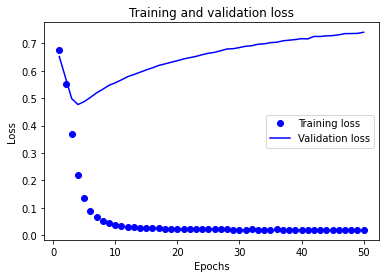

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The model started overfitting from the 10th epoch. Let's retrain it for 10 epochs

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

In [ ]:

##########
n_latent_factors=10
model=models.Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=n_latent_factors,input_length=   max_length,
                           trainable=True))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation="sigmoid"))
# compile the model
model.compile(optimizer  = optimizers.Adam(lr=0.01),loss='binary_crossentropy', metrics=['acc'] )
# summarize the model
model.summary()
# fit the model
history=model.fit(x_train, y_train, epochs=10,batch_size=512,
                  validation_data =  (x_val,y_val))
# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 23, 10)            183580    
_________________________________________________________________
flatten_8 (Flatten)          (None, 230)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 231       
Total params: 183,811
Trainable params: 183,811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12/12 [==============================] - 1s 24ms/step - loss: 0.6770 - acc: 0.5595 - val_loss: 0.6209 - val_acc: 0.6718
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.5340 - acc: 0.8211 - val_loss: 0.5042 - val_acc: 0.7807
Epoch 3/10
12/12 [==============================] - 0s 11ms/step - loss: 0.3331 - acc: 0.9084 - val_loss: 0.4468 - 

In [ ]:
results = model.evaluate(x_val, y_val)

48/48 [==============================] - 0s 998us/step - loss: 0.5588 - acc: 0.7907


loss: 0.5588 - acc: 0.7907

I tried increasing latent_features to 100 but the loss increased to 0.7

In [ ]:
test=padded_docs[7521:]

In [ ]:
test

,id,keyword,location,text,target
7521,0,NaN,NaN,happen terrible car crash,NaN
7522,2,NaN,NaN,hear earthquake different city stay safe everyone,NaN
...,...,...,...,...,...
10782,10874,NaN,NaN,meg issue hazardous weather outlook hwo,NaN
10783,10875,NaN,NaN,cityofcalgary activate municipal emergency pla...,NaN


In [ ]:
submission = pd.read_csv("sample_submission.csv")
test_pred = model.predict(test)
test_pred_int = test_pred.round().astype('int')
submission['target'] = test_pred_int
submission.to_csv('submission.csv', index=False)

Score
submission.csv
a few seconds ago
1 seconds
0 seconds
0.78057

Great kernels:
- https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
- https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
- https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
- https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert>> visualize embeddings, count vectorizer

- https://ai.plainenglish.io/nlp-my-solution-to-kaggles-disaster-tweet-competition-9973ddf48235 >>xgbboost

- https://www.kaggle.com/philculliton/nlp-getting-started-tutorial>>ridge